<h1 style="text-align: center">计算机视觉第二次作业　人脸对齐</h1>
<h3 style="text-align: center">学号：2006022　姓名：齐林</h3>

### **题目**：实现人脸对齐算法

-   检测人脸关键点
    -   自选：dlib，openpose，alphapose，face++ api
-   对齐后，
    -   人脸 5 个关键点（左右眼中心、鼻尖、嘴角）位置坐标
        -   (75,125) (125,125) (100,160) (80,180) (125,180)
        -   两眼间距 50，眼睛距离上边界是 125
    -   图像大小是 250\*200 像素
-   求解变换矩阵 T
-   使用仿射变换，进行映射

### 以下为实现过程：

由于我对 opencv 的函数比较熟悉，所以我选择使用 opencv 作为处理的工具

1. 读入图片，由于 opencv 读入的图片是 BGR 的，使用 pyplot 显示需要转换为 RGB


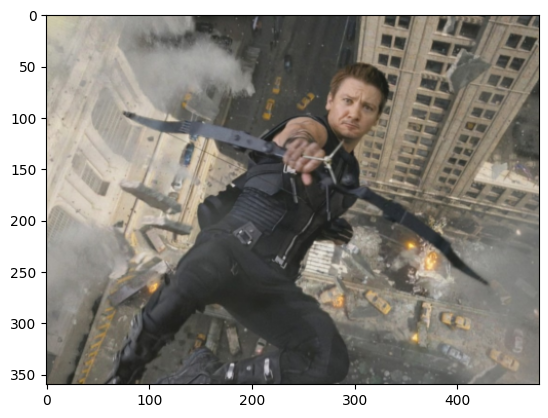

In [18]:
import cv2
from matplotlib import pyplot as plt


def read_image(path: str):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    return img


src = read_image("./src.png")


2. 使用 face++ 的 api 检测人脸关键点，并将返回转为 json
   为了避免每次都要调用 api，我将返回的 json 保存为 json 文件，下次直接读取


In [19]:
import json
import os
import requests


def face_pp_api(path: str):
    if os.access(f"{path}.json", os.F_OK):
        print("file exists, read from file")
        with open(f"{path}.json", "r") as f:
            face_pp = json.load(f)
        return face_pp
    else:
        print("file not exists, request from api")
        url = "https://api-cn.faceplusplus.com/facepp/v1/face/thousandlandmark"
        data = {
            "api_key": "j2KqgidTRFwPnWuYvpoH_DX-o-9g-aSt",
            "api_secret": "-wNVJSJA_oAwvbTPXDkFB6y0pwcjotLs",
            "return_landmark": "all",
        }
        image_file = {
            "image_file": open(path, "rb"),
        }
        res = requests.post(url, data=data, files=image_file)
        face_pp = json.loads(res.text)
        with open(f"{path}.json", "w") as f:
            json.dump(face_pp, f, indent=4)
        return face_pp


face_pp = face_pp_api("./src.png")


file exists, read from file


3. 返回值中有人脸矩形框的位置，将其画出，验证拿到的数据是否正确

-   face_pp["face"]["face_rectangle"] 中每个值的含义：
    -   top：矩形框左上角像素点的纵坐标
    -   left：矩形框左上角像素点的横坐标
    -   width：矩形框的宽度
    -   height：矩形框的高度


{'width': 45, 'top': 78, 'height': 44, 'left': 274}


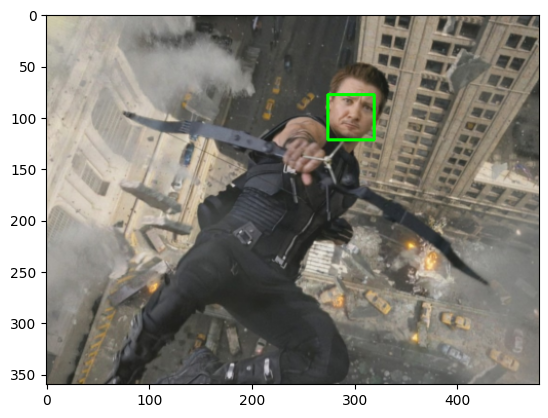

In [20]:
import numpy as np


def draw_rect(src: np.ndarray, face_pp: dict):
    rect = face_pp["face"]["face_rectangle"]
    print(rect)
    dst = src.copy()
    dst = cv2.rectangle(
        dst,
        (rect["left"], rect["top"]),
        (rect["left"] + rect["width"], rect["top"] + rect["height"]),
        (0, 255, 0),
        2
    )
    plt.imshow(dst)
    plt.show()
    return dst


dst = draw_rect(src, face_pp)


4. 根据 api 分别获取 5 个关键点的坐标，并将其画出

-   左眼中心和右眼中心都有直接的坐标，但是鼻尖和嘴角的坐标需要通过计算得到
-   鼻尖通过左鼻孔和右鼻孔的坐标计算得到
-   嘴角通过上嘴唇的上边缘和上嘴唇的下边缘以及下嘴唇的下边缘和下嘴唇的上边缘计算得到


[[294, 84], [312, 90], [298.5, 100.0], [290.0, 106.0], [303.0, 109.75]]


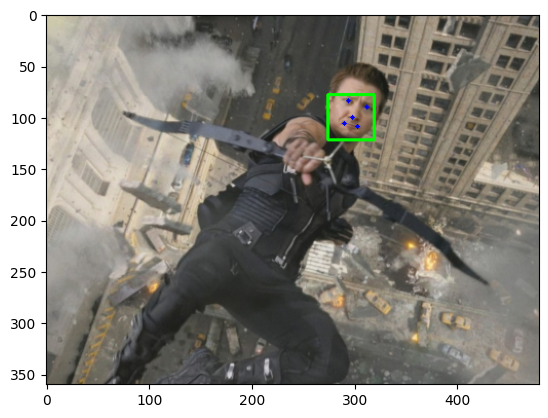

In [21]:
def get_key_points(face_pp: dict):
    landmark = face_pp["face"]["landmark"]
    left_eye = landmark["left_eye"]
    right_eye = landmark["right_eye"]
    nose = landmark["nose"]
    mouth = landmark["mouth"]

    key_points = [
        [left_eye["left_eye_pupil_center"]["x"],
         left_eye["left_eye_pupil_center"]["y"]],
        [right_eye["right_eye_pupil_center"]["x"],
         right_eye["right_eye_pupil_center"]["y"]],

        [(nose["left_nostril"]["x"] + nose["right_nostril"]["x"]) / 2,
         (nose["left_nostril"]["y"] + nose["right_nostril"]["y"]) / 2],
        [(mouth["upper_lip_0"]["x"] + mouth["upper_lip_63"]["x"]
          + mouth["lower_lip_0"]["x"] + mouth["lower_lip_63"]["x"]) / 4,
         (mouth["upper_lip_0"]["y"] + mouth["upper_lip_63"]["y"]
          + mouth["lower_lip_0"]["y"] + mouth["lower_lip_63"]["y"]) / 4],
        [(mouth["upper_lip_31"]["x"] + mouth["upper_lip_32"]["x"]
          + mouth["lower_lip_31"]["x"] + mouth["lower_lip_31"]["x"]) / 4,
         (mouth["upper_lip_31"]["y"] + mouth["upper_lip_32"]["y"]
         + mouth["lower_lip_32"]["y"] + mouth["lower_lip_32"]["y"]) / 4],
    ]
    print(key_points)
    return key_points


def draw_key_points(dst: np.ndarray, key_points: list):
    for point in key_points:
        cv2.circle(dst, (int(point[0]), int(point[1])), 2, (0, 0, 255), -1)
    plt.imshow(dst)
    plt.show()
    return dst


key_points = get_key_points(face_pp)
dst = draw_key_points(dst, key_points)


5. 计算变换矩阵并使用仿射变换进行映射


[[   2.49042146    0.86206897 -729.59770115]
 [  -0.8045977     2.4137931   158.79310345]]


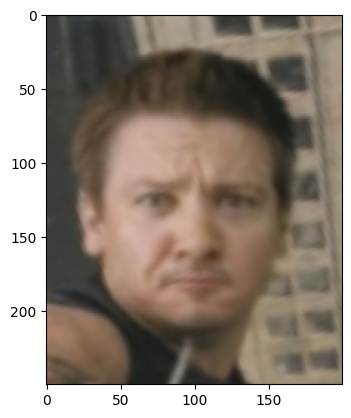

[[   2.49042146    0.86206897 -729.59770115]
 [  -0.8045977     2.4137931   158.79310345]]


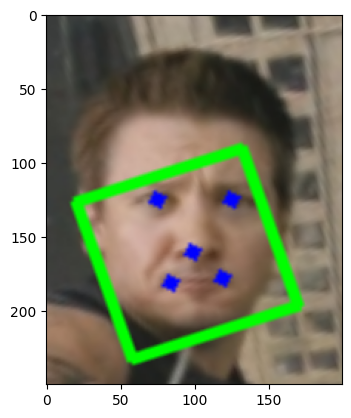

In [22]:
def affine_transformation(
    img: np.ndarray,
    key_points: list,
    dst_points: list,
    filename=""
):
    T = cv2.getAffineTransform(
        np.asarray(key_points[: 3], dtype=np.float32),
        np.asarray(dst_points[: 3], dtype=np.float32)
    )
    print(T)
    img = cv2.warpAffine(img.copy(), T, (200, 250))
    plt.imshow(img)
    plt.show()
    if filename != "":
        plt.imsave(filename, img)


dst_points = [[75, 125], [125, 125], [100, 160], [80, 180], [125, 180]]
affine_transformation(src, key_points, dst_points, "./src_ans1.png")
affine_transformation(dst, key_points, dst_points, "./src_ans2.png")


### 结果分析

1. face++拥有比较完备的 api 和技术文档，使用起来比较方便。但是在注册的时候有点问题，应该是前后端写的有点问题
2. OpenCV 提供了非常多的图像处理和算法接口，包括使用到的拆分图像通道，在图像上进行标注，求变换矩阵和进行仿射变换等
3. 由于算法细节都被写入了函数所以只要直接使用就能完成任务
4. 在课程 ppt 上面最终人脸对齐的结果中，人眼的位置并不在图像竖直方向上的中间，而是更偏上一点，而要求人眼位置正好在图像竖直方向上的正中间，所以看起来有点奇怪，不是很自然
5. 实现的步骤全部写在了函数中，读入的图片没有修改过，所有的修改都在 copy 后的对象上


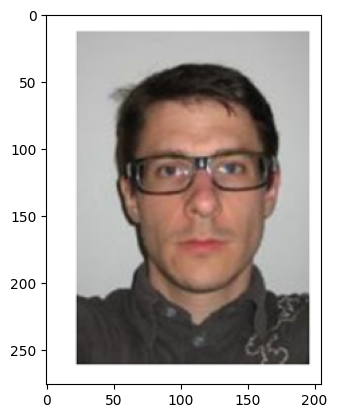

file exists, read from file
{'width': 104, 'top': 100, 'height': 104, 'left': 63}


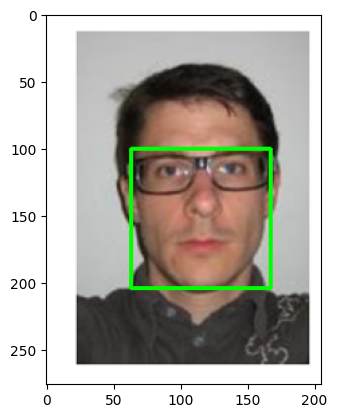

[[92, 116], [137, 114], [118.5, 145.0], [100.25, 171.25], [130.75, 169.5]]


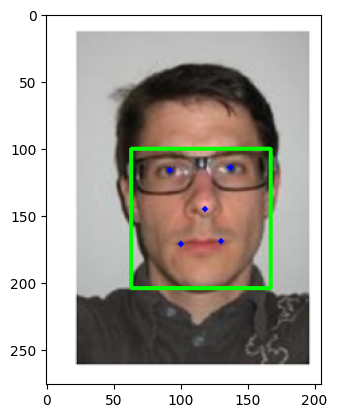

[[  1.10456554  -0.14727541  -9.53608247]
 [  0.05154639   1.15979381 -14.27835052]]


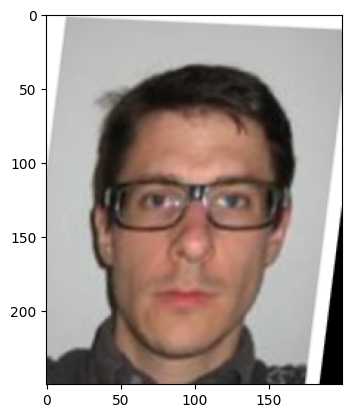

In [24]:
example = read_image("./example.png")
face_pp = face_pp_api("./example.png")
dst = draw_rect(example, face_pp)
key_points = get_key_points(face_pp)
dst = draw_key_points(dst, key_points)
affine_transformation(example, key_points, dst_points, "example_ans.png")
